# Quantifying Entity Novelty
- Exposure (see Carlini et al. 2019)
- Factual Test
- Utilization of a music entities published after the knowledge cut


In [1]:
import pandas as pd
import os

path_exposure = "../data/intermediate/shs100k2_exposure.jsonl"
path_memorizations = "../output/memorization2"

data_wd = pd.read_json(path_exposure, lines=True, orient="records")

data_perfs = pd.read_parquet("../data/raw/shs100k2_yt.parquet")[
    ["set_id", "title", "performer"]].groupby("set_id", as_index=False).agg(list)

__ = []
files = os.listdir(path_memorizations)
for f in files:
    __data = pd.read_json(os.path.join(path_memorizations, f), lines=True, orient="records")
    if "set_id" in __data.columns:
        __data = pd.merge(__data, data_perfs, how="left", on="set_id")
        __data["filename"] = f
        __.append(__data)

data = pd.concat(__)
data["Model"] = data.filename.str.replace(
    "llama3.1-70b.jsonl", "Llama3.1-70B").str.replace(
        "llama3.1-8b.jsonl", "Llama3.1-8B")
           

In [2]:
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import (unicode_normalize, remove_brackets_and_all_content, 
                   remove_bracket_only, replace_linebreaks_tabs)
processing_attrs = ["artist_original", "artist_perf", "composer"]
preprocessor = PerformerStringPreprocessor()


def preprocessing(s: str) -> str:
        s = unicode_normalize(s)
        # remove brackets with one-word content eg "[us]"
        s = remove_brackets_and_all_content(s)
        # remove brackets but keep content, eg. when (feat. Metallica) keep feat. Metallica
        s = remove_bracket_only(s)
        # split performers by defined separators
        l = preprocessor.split_performers(replace_linebreaks_tabs(s))
        # also consider performer names without artists
        l = preprocessor.article_preprocessing(l)
        return ','.join(l)

data.artist_original = data.artist_original.apply(lambda x: preprocessing(x) if type(x) == str else None)
data.artist_perf = data.artist_perf.apply(lambda x: preprocessing(x) if type(x) == str else None)
data.composer = data.composer.apply(lambda x: preprocessing(x) if type(x) == str else None)


In [3]:
def AW1_correct(row):
    if row.AW1 and row.artist_original:
        aws = row.AW1.split()
        return any([aw.lower() in [a.lower() for a in row.artist_original.split()] for aw in aws])
    return

def artist_partly_correct(row, answer_col: str):
    if row[answer_col] and row.performer:
        artists = row[answer_col].split()
        if row.artist_original:
            artists += row.artist_original.split()
        if row.composer:
            artists += row.composer.split()
        for artist in artists:
            for performer in row.performer:
                if artist in performer:
                    return True
    else: 
        return None
    return False

# FIXME: dropped!
# def AW2_correct(row):
#     if row.AW2 and row.artist_perf:
#         aws = row.AW2.split()
#         return any([aw.lower() in [a.lower() for a in row.artist_perf.split()] for aw in aws])
#     return

def AW2_correct(row):
    if row.AW3 and row.composer:
        aws = row.AW3.split()
        return any([aw.lower() in [c.lower() for c in row.composer.split()] for aw in aws])
    return

data["AW1: Correct"] = data.apply(AW1_correct, axis=1)
data["AW1: Related"] = data.apply(lambda x: artist_partly_correct(x, "AW1"), axis=1)

data["AW2: Correct"] = data.apply(AW2_correct, axis=1)
data["AW2: Related"] = data.apply(lambda x: artist_partly_correct(x, "AW2"), axis=1)

# data["AW3: Correct"] = data.apply(AW3_correct, axis=1)
# data["AW3: Related"] = data.apply(lambda x: artist_partly_correct(x, "AW3"), axis=1)


In [4]:

id_cols = ['set_id', 'work_id', 'perf_id', 'Model']
aw_cols = [col for col in data.columns if col.startswith('AW') and ":" in col]

data[id_cols + aw_cols]

data_melted = data.melt(id_vars=id_cols, value_vars=aw_cols)

data_melted_pivoted = data_melted.pivot_table(
    index=['set_id', 'work_id', 'perf_id'],
    columns=['Model', 'variable'],
    values='value',
    aggfunc='first'  # 'first' because we assume there is no aggregation needed if values are unique
)
data_melted_pivoted.reset_index().to_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")
data_melted_pivoted


Model                    Llama3.1-70B                                         \
variable                 AW1: Correct AW1: Related AW2: Correct AW2: Related   
set_id work_id  perf_id                                                        
0      4681.0   132979.0        False         True         True         True   
1      7895.0   7895.0           True         True         True         True   
2      7896.0   86970.0          True        False         True        False   
3      12959.0  507152.0        False        False         True        False   
4      312438.0 51032.0          True         True        False         True   
...                               ...          ...          ...          ...   
9992   97193.0  97193.0         False         True        False        False   
                97194.0         False         True        False        False   
9993   9750.0   9750.0           True         True        False         True   
9994   98356.0  98356.0          True        False        False        False   
9998   9900.0   9900.0          False        False        False         True   

Model                     Llama3.1-8B                                         
variable                 AW1: Correct AW1: Related AW2: Correct AW2: Related  
set_id work_id  perf_id                                                       
0      4681.0   132979.0        False         True         True         True  
1      7895.0   7895.0           True         True         True         True  
2      7896.0   86970.0          True        False         True        False  
3      12959.0  507152.0        False         True         True         True  
4      312438.0 51032.0         False         True        False         True  
...                               ...          ...          ...          ...  
9992   97193.0  97193.0         False        False        False        False  
                97194.0         False        False         True        False  
9993   9750.0   9750.0           True         True        False         True  
9994   98356.0  98356.0         False        False        False         True  
9998   9900.0   9900.0          False        False        False        False  

[10104 rows x 8 columns]

In [5]:
data_melted_pivoted[data_melted_pivoted[("Llama3.1-70B", "AW1: Correct")].isna()]


Model                    Llama3.1-70B                                         \
variable                 AW1: Correct AW1: Related AW2: Correct AW2: Related   
set_id work_id  perf_id                                                        
8103   116960.0 148505.0          NaN        False        False        False   
9080   2725.0   2725.0            NaN          NaN        False         True   

Model                     Llama3.1-8B                                         
variable                 AW1: Correct AW1: Related AW2: Correct AW2: Related  
set_id work_id  perf_id                                                       
8103   116960.0 148505.0          NaN        False        False        False  
9080   2725.0   2725.0          False        False         True        False

# Analysis

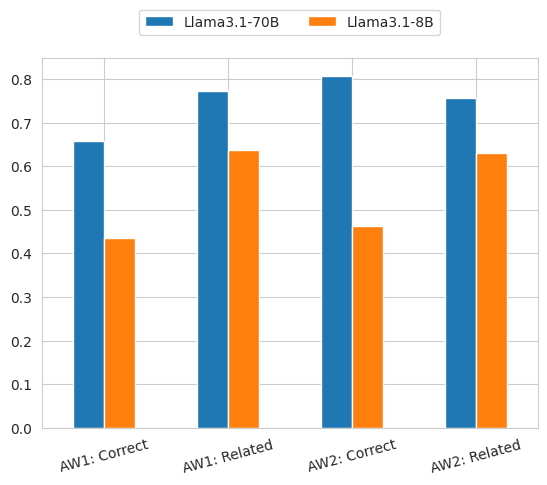

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

__data = data_melted_pivoted.sum().unstack(level=0) 
prob = lambda x: x / data.set_id.nunique()
__data = __data.apply(prob)
__data.plot(kind="bar")

plt.xticks(rotation=15)
plt.xlabel("")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.savefig("../figures/memorization_test.pdf")
plt.show()
